# Virtual Screening of SARS-CoV-2 Main-Protease Inhibitors

## Preliminaries

In [125]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

import umap
from sklearn.decomposition import KernelPCA, PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel
from sklearn.model_selection import train_test_split

## Exploratory Data Analysis

### Data Cleaning

In [126]:
# load data, drop rows missing both targets 
path = 'covid_submissions_all_info.csv'
df = pd.read_csv(path).dropna(subset=['r_avg_IC50', 'f_avg_IC50'], how='all')

# check that we can safely drop SMILES duplicates; we can
smiles_counts = df['SMILES'].value_counts()
for i, num in enumerate(smiles_counts):
    if num > 1:
        tmp = df[df['SMILES']==smiles_counts.index[i]][['f_avg_IC50', 'r_avg_IC50']]
        assert(tmp.drop_duplicates().shape[0] == 1)
print('All duplicated SMILES have the same IC50 values. Dropping ...')
df = df.drop_duplicates(subset=['SMILES'], keep='first')

All duplicated SMILES have the same IC50 values. Dropping ...


How well do the different assays predict each other?

Let's calculate a correlation $$R_{ij} = \frac{cov(i,j)}{\sqrt{cov(i,i)cov(j,j)}}$$ where $$cov(i,j) = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{N}$$

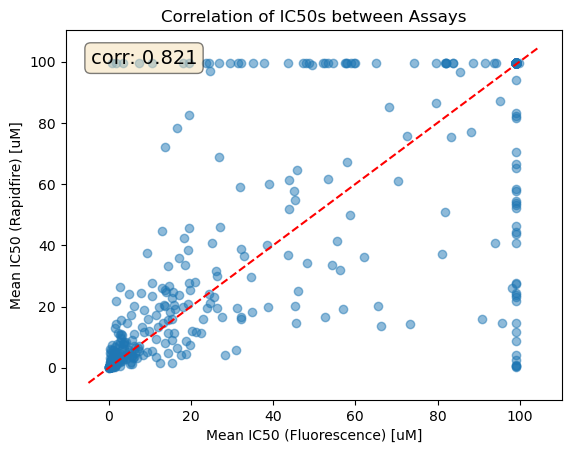

In [137]:
# where both targets present, plot scatterplot and calculate correlation
def target_scatter(df, targets=['r_avg_IC50', 'f_avg_IC50'], 
                   xlab='Mean IC50 (Fluorescence) [uM]', 
                   ylab='Mean IC50 (Rapidfire) [uM]',
                   title='Correlation of IC50s between Assays'):
    plotdf = df.dropna(subset=targets, how='any')

    plt.scatter(plotdf[targets[0]], plotdf[targets[1]], alpha=0.5)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

    corr = np.corrcoef(plotdf[targets[0]], plotdf[targets[1]], )[0, 1]
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, f'corr: {corr:.3f}', transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    x = np.linspace(*plt.xlim())
    plt.plot(x, x, '--', color='red', label='y=x')
    plt.show()

target_scatter(df)

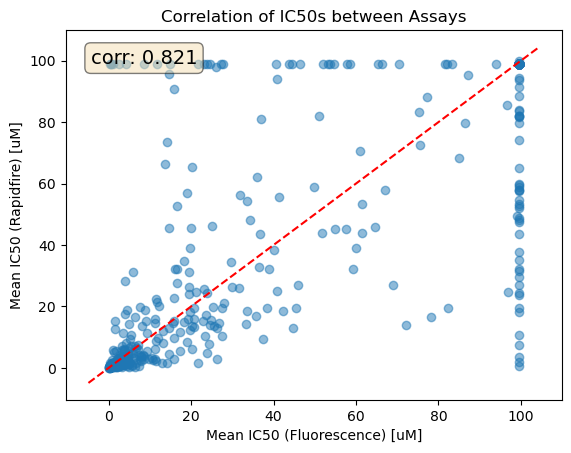

In [128]:
# remove extreme outlier and recalculate
def read_and_clean_data(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['r_avg_IC50', 'f_avg_IC50'], how='all')
    df = df.drop_duplicates(subset=['SMILES'], keep='first')
    df = df[df['f_avg_IC50']<=100] # removes extreme outliers
    dfs = df[['SMILES','CID','f_avg_IC50','r_avg_IC50']]
    return df, dfs

df, dfs = read_and_clean_data('covid_submissions_all_info.csv')

target_scatter(dfs)

### Transforming the Target Variables

Let's transform the data as:

$$\text{pIC}_{50} = -\log_{10}({\text{IC}_{50}} \ [\text{M}])$$

This gives us:
* unimodality
* interesting values near $\text{IC}_{50}\approx 0$ stretched towards $=+\infty$
* problematic values near assay saturation limit $\text{IC}_{50}\approx 100$ squished towards zero

Text(0, 0.5, 'pIC50')

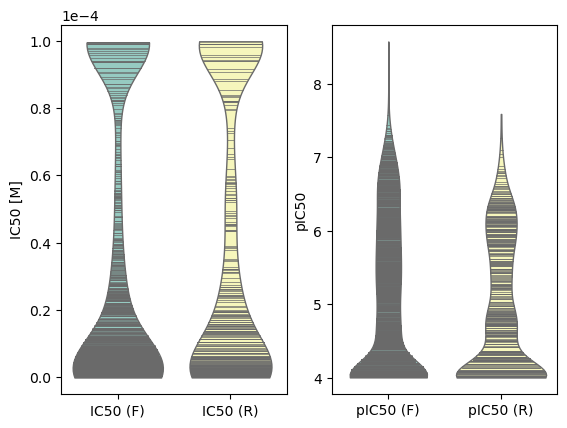

In [129]:
# log-transform targets to improve distribution
dfs[['f_pIC50', 'r_pIC50']] = dfs[['f_avg_IC50','r_avg_IC50']].apply(lambda x: -np.log10(x*1e-6)) # conversion from MICRO molar = 1e-6 molar

fig, axs = plt.subplots(1, 2)
violin_plot = sns.violinplot(data=dfs[['f_avg_IC50', 'r_avg_IC50']]*1e-6, 
                                palette="Set3", bw=.2, cut=0, linewidth=1, ax=axs[0], inner='stick', density_norm='count')
violin_plot.set_xticklabels(['IC50 (F)', 'IC50 (R)'])
violin_plot.set_ylabel('IC50 [M]')
violin_plot.yaxis.get_major_formatter().set_powerlimits((0,1)) # format yticklabels in scientific notation

violin_plot2 = sns.violinplot(data=dfs[['f_pIC50', 'r_pIC50']], 
                                palette="Set3", bw=.2, cut=0, linewidth=1, ax=axs[1], inner='stick', density_norm='count')
violin_plot2.set_xticklabels(['pIC50 (F)', 'pIC50 (R)'])
violin_plot2.set_ylabel('pIC50')

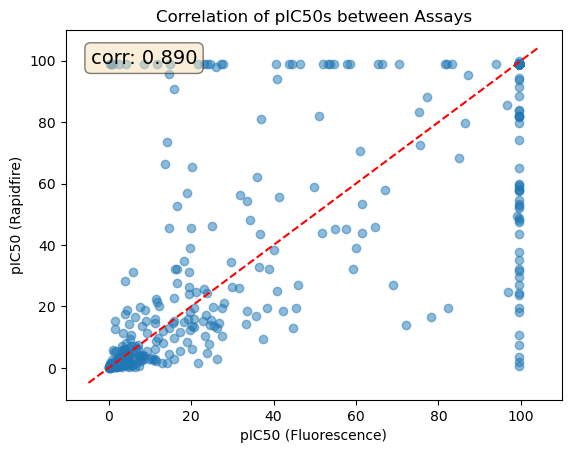


Summary statistics for potential targets:


,r_pIC50,f_pIC50
count,528.000000,1952.000000
mean,4.918872,5.069130
std,0.922385,1.043749
min,4.000862,4.002177
25%,4.004365,4.002177
50%,4.687423,4.837135
75%,5.790397,5.948766
max,7.587379,8.573820


In [130]:
target_scatter(dfs, targets=['r_pIC50', 'f_pIC50'],
               xlab='pIC50 (Fluorescence)', ylab='pIC50 (Rapidfire)', 
               title='Correlation of pIC50s between Assays')

The transformed targets seem slightly better behaved.

Let's pick the one with more known values as our regression target.

In [138]:
# descriptive statistics of both potential targets
print('\nSummary statistics for potential targets:')
dfs[['r_pIC50', 'f_pIC50']].describe()


Summary statistics for potential targets:


,r_pIC50,f_pIC50
count,528.000000,1952.000000
mean,4.918872,5.069130
std,0.922385,1.043749
min,4.000862,4.002177
25%,4.004365,4.002177
50%,4.687423,4.837135
75%,5.790397,5.948766
max,7.587379,8.573820


### Molecular Representation

We use 1024-bit Morgan Fingerprints (radius=2).

In [131]:
# get fingerprints
dfs['Morgan'] = dfs['SMILES'].apply(lambda smiles: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, 1024))

To get a sense of this space, we apply dimensionality reduction and colour by $\text{pIC}_{50}$:

* PCA
* KernelPCA
    * instead of calculating the covariance matrix in feature space $\mathbf{C}=\frac{1}{N}\sum_{i=1}^{N}\mathbf{X}\mathbf{X}^{T}$
    * map the data to an infinite-dimensional space first: $\mathbf{\Phi}(\mathbf{X})$
    * caluclate covariance in that space: $\mathbf{C^\prime}=\frac{1}{N}\sum_{i=1}^{N}\mathbf{\Phi}(\mathbf{X})\mathbf{\Phi}(\mathbf{X})^{T}$
    * do this implicitly, by defining an inner product ('kernel', in out case radial basis function)
    $$k(x_i,x_j) = \phi(x_i)^T\phi(x_j)=\exp\Big(-\gamma * ||x_i-x_j||^2\Big)$$
* UMAP

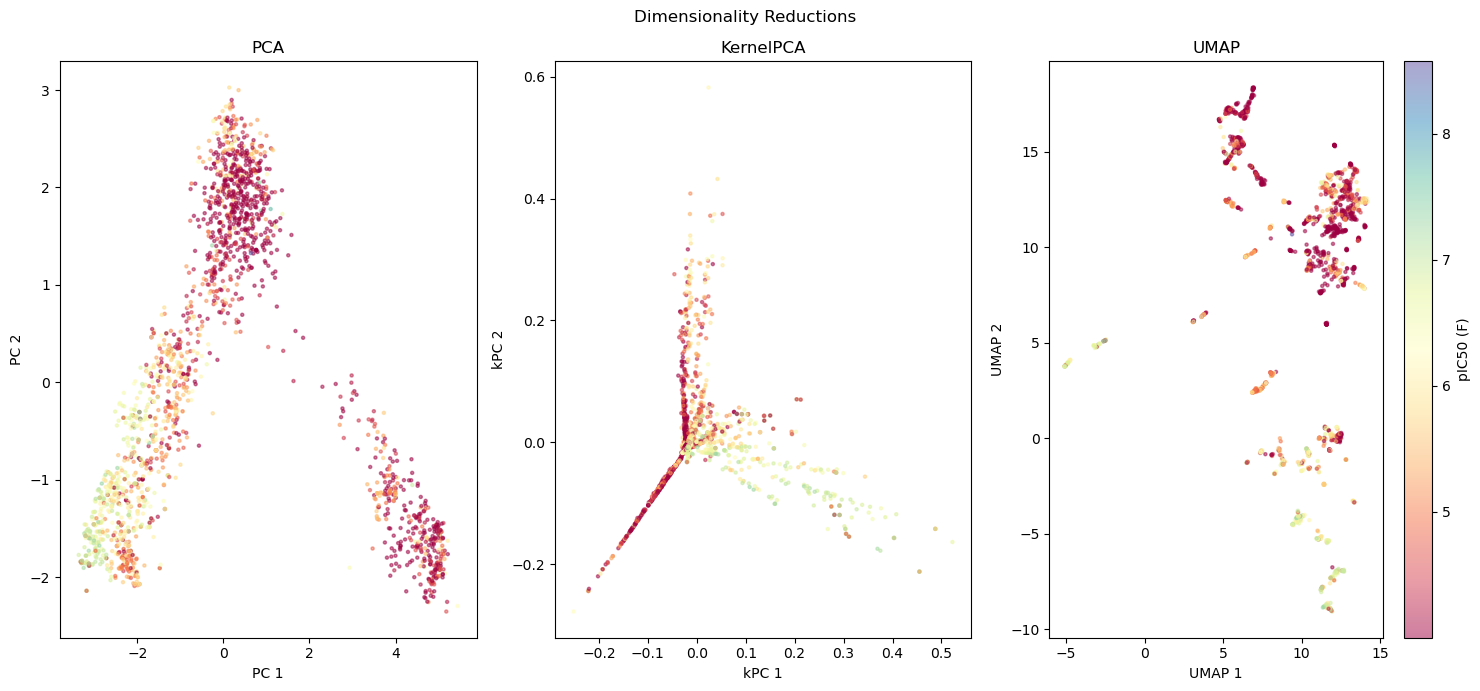

In [132]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
fig.suptitle('Dimensionality Reductions')

# PCA plot of fingerprints
pca = PCA(n_components=2)
pca.fit(dfs['Morgan'].tolist())
embedding = pca.transform(dfs['Morgan'].tolist())
scatter = axs[0].scatter(embedding[:, 0], embedding[:, 1], c=dfs['f_pIC50'], cmap='Spectral', s=5, alpha=0.5)
axs[0].set_title('PCA')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

# KernelPCA plot of fingerprints
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, n_jobs=-1)
kpca.fit(dfs['Morgan'].tolist())
embedding = kpca.transform(dfs['Morgan'].tolist())
scatter = axs[1].scatter(embedding[:, 0], embedding[:, 1], c=dfs['f_pIC50'], cmap='Spectral', s=5, alpha=0.5)
axs[1].set_title('KernelPCA')
axs[1].set_xlabel('kPC 1')
axs[1].set_ylabel('kPC 2')

# UMAP plot of fingerprints
reducer = umap.UMAP(metric='jaccard', random_state=0)
embedding = reducer.fit_transform(dfs['Morgan'].tolist())
scatter = axs[2].scatter(embedding[:, 0], embedding[:, 1], c=dfs['f_pIC50'], cmap='Spectral', s=5, alpha=0.5)
fig.colorbar(scatter, ax=axs[2], label='pIC50 (F)')
axs[2].set_title('UMAP')
axs[2].set_xlabel('UMAP 1')
axs[2].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

## Gaussian Process Model

In [133]:
X, y = dfs['Morgan'].to_list(), dfs['f_pIC50'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y) # 0.75/0.25 train/test split

r_squared, log_likeli, preds = [], [], []
len_scales = [0.1,1,5,8,10,15,20,30,50]
for len_scale in tqdm(len_scales):
    kernel = RBF(len_scale, length_scale_bounds="fixed") + WhiteKernel() + ConstantKernel()
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train, y_train)
    r_squared.append(gpr.score(X_test, y_test))
    log_likeli.append(gpr.log_marginal_likelihood())

# get max r_squared and corresponding len_scale
max_log_likeli = max(log_likeli)
max_len_scale = len_scales[log_likeli.index(max_log_likeli)]
corresponding_r_squared = r_squared[log_likeli.index(max_log_likeli)]

print(f'Max log-likelihood={max_log_likeli:.3f} at length-scale={max_len_scale:.3f}; R^2: {corresponding_r_squared:.3f} ')

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [03:26<00:00, 22.90s/it]

Max log-likelihood=-1504.629 at length-scale=10.000; R^2: 0.637 


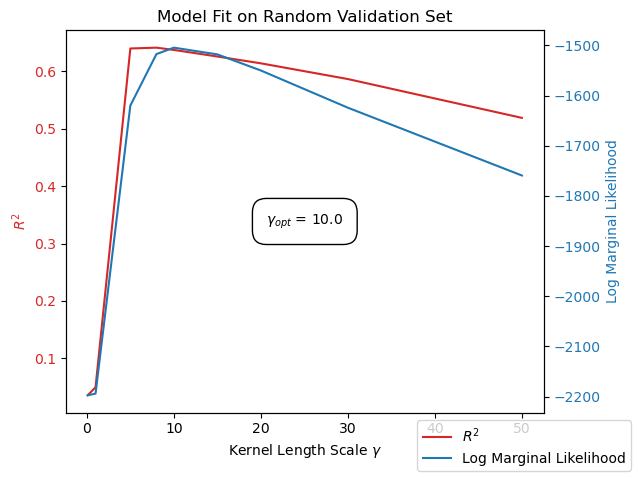

In [134]:
# plot change of fit over grid of length-scales
fig, ax1 = plt.subplots()

plt.title('Model Fit on Random Validation Set')

color = 'tab:red'
ax1.set_xlabel('Kernel Length Scale '+r'$\gamma$')
ax1.set_ylabel(r'$R^{2}$', color=color)
line1, = ax1.plot(len_scales, r_squared, color=color, label=r'$R^{2}$')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Log Marginal Likelihood', color=color)  
line2, = ax2.plot(len_scales, log_likeli, color=color, label='Log Marginal Likelihood')
ax2.tick_params(axis='y', labelcolor=color)

plt.text(0.5, 0.5, r'$\gamma_{opt}$' + f' = {max_len_scale:.1f}', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes,
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

fig.tight_layout()  
fig.legend(handles=[line1, line2], loc='lower right')
plt.show()

In [135]:
# re-fit on all the data
kernel_opt = RBF(max_len_scale, length_scale_bounds="fixed") + WhiteKernel() + ConstantKernel()
gpr_opt = GaussianProcessRegressor(kernel=kernel_opt).fit(X, y)
rsquared_on_all = gpr.score(X, y)
y_pred, sigma = gpr_opt.predict(X, return_std=True)

print('R^2 on all data:', rsquared_on_all)

R^2 on all data: 0.5282888364342818


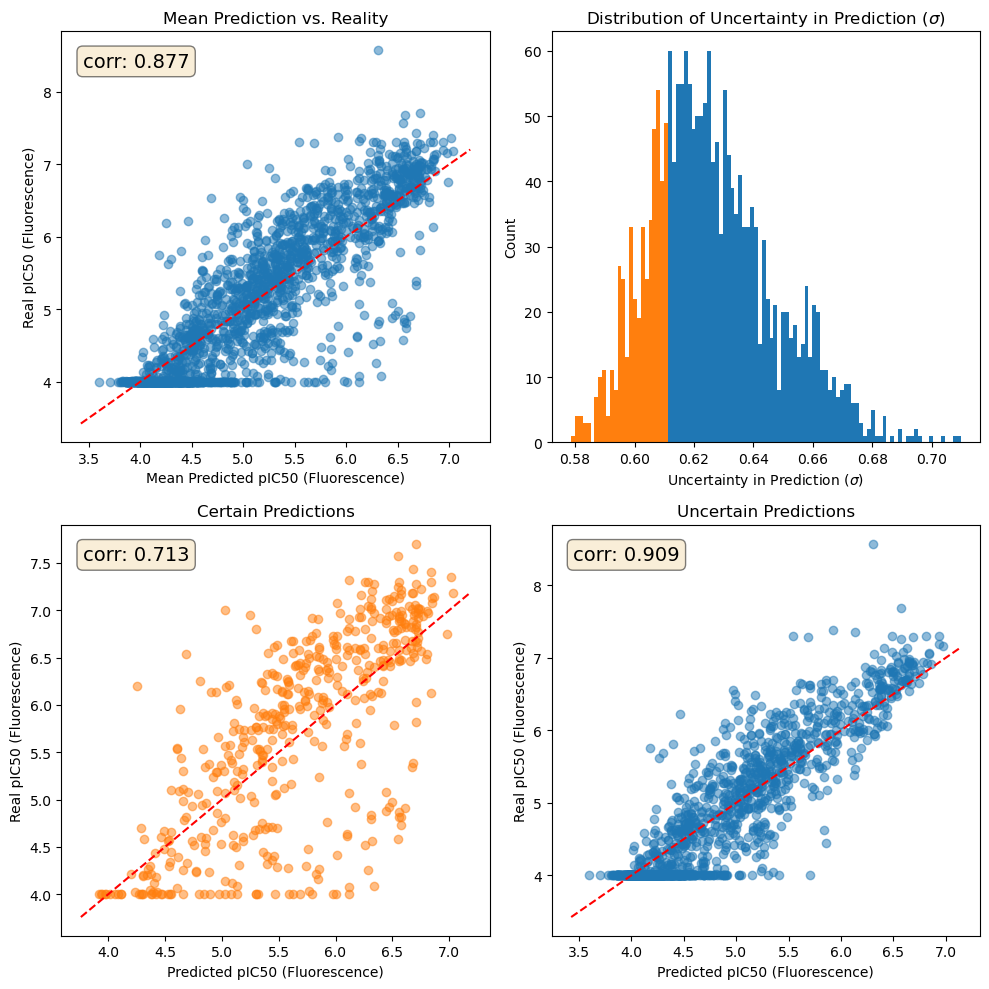

In [136]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Subplot 1: Prediction vs. Reality
axs[0, 0].scatter(y_pred, y, alpha=0.5) 
axs[0, 0].set_xlabel('Mean Predicted pIC50 (Fluorescence)')
axs[0, 0].set_ylabel('Real pIC50 (Fluorescence)')
axs[0, 0].set_title('Mean Prediction vs. Reality')

corr = np.corrcoef(y_pred, y)[0, 1]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[0, 0].text(0.05, 0.95, f'corr: {corr:.3f}', transform=axs[0, 0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

x = np.linspace(*axs[0, 0].get_xlim())
axs[0, 0].plot(x, x, '--', color='red', label='y=x')

# Subplot 2: Distribution of Uncertainty in Prediction
lowest_quartile = np.quantile(sigma, 0.25)
axs[0, 1].hist(sigma[sigma>lowest_quartile], bins=75)
axs[0, 1].hist(sigma[sigma<lowest_quartile], bins=25)

axs[0, 1].set_xlabel('Uncertainty in Prediction ($\sigma$)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_title(r'Distribution of Uncertainty in Prediction ($\sigma$)')

# Subplot 3: Certain Predictions
certain = np.array(sigma) < lowest_quartile
certain_preds = np.array(y_pred)[certain]
certain_y = np.array(y)[certain]
axs[1, 0].scatter(certain_preds, certain_y, alpha=0.5, color='#ff7f0e')
axs[1, 0].set_xlabel('Predicted pIC50 (Fluorescence)')
axs[1, 0].set_ylabel('Real pIC50 (Fluorescence)')
axs[1, 0].set_title('Certain Predictions')

corr = np.corrcoef(certain_preds, certain_y)[0, 1]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1, 0].text(0.05, 0.95, f'corr: {corr:.3f}', transform=axs[1, 0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

x = np.linspace(*axs[1, 0].get_xlim())
axs[1, 0].plot(x, x, '--', color='red', label='y=x')

# Subplot 4: Uncertain Predictions
uncertain = np.array(sigma) > lowest_quartile
uncertain_preds = np.array(y_pred)[uncertain]
uncertain_y = np.array(y)[uncertain]
axs[1, 1].scatter(uncertain_preds, uncertain_y, alpha=0.5)
axs[1, 1].set_xlabel('Predicted pIC50 (Fluorescence)')
axs[1, 1].set_ylabel('Real pIC50 (Fluorescence)')
axs[1, 1].set_title('Uncertain Predictions')

corr = np.corrcoef(uncertain_preds, uncertain_y)[0, 1]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs[1, 1].text(0.05, 0.95, f'corr: {corr:.3f}', transform=axs[1, 1].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

x = np.linspace(*axs[1, 1].get_xlim())
axs[1, 1].plot(x, x, '--', color='red', label='y=x')

plt.tight_layout()
plt.show()
